In [5]:

from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(
    os.environ.get('WORK_DIR')) #type: ignore
sys.path.append(
    os.environ.get('DBASE_DIR')) #type: ignore
from dbase.DataAPI.ThetaData import * #type: ignore
from dbase.database.SQLHelpers import * #type: ignore
import pandas as pd
from EventDriven.data import HistoricTradeDataHandler
from EventDriven.event import *
from queue import Queue
from trade.backtester_.backtester_ import PTDataset, PTBacktester
import pandas_ta as ta
from trade.assets.Stock import Stock
from trade.backtester_.utils.WalkForwardUtils import prev_monday 
from trade.backtester_.strats import BBandsTrend2
from trade.backtester_.strats import MAStrat
import yfinance as yf
from datetime import datetime
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
thetadata_start = '2021-01-01'

In [7]:
import json
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
key = 11
with open(f'../input/profitable_weights_{key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'../input/profitable_trades_{key}.csv').iloc[:, 1:]
ttrades__['Duration'] = ttrades__.Duration.apply(lambda x: int(x.split(' ')[0]))
# ttrades__ = ttrades__[ttrades__.Duration>0]
ttrades__#.Ticker.unique()

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,23,502,511,249.189127,202.630005,-1070.859817,-0.186843,2024-01-03,2024-01-17,14,BA
1,65,502,533,184.864771,183.419998,-93.910249,-0.007815,2024-01-03,2024-02-16,44,AAPL
2,117,502,585,136.184992,145.509995,1091.025324,0.068473,2024-01-03,2024-05-02,120,AMD
3,44,502,637,346.187441,475.000000,5667.752595,0.372089,2024-01-03,2024-07-18,197,META
4,16,502,752,653.489257,923.650024,4322.572278,0.413413,2024-01-03,2024-12-31,363,COST
5,10,502,752,468.955627,901.799988,4328.443604,0.922996,2024-01-03,2024-12-31,363,NFLX
6,559,509,752,54.811169,138.029999,46519.325887,1.518282,2024-01-12,2024-12-31,354,NVDA
7,26,521,649,157.549500,154.210007,-86.826825,-0.021196,2024-01-31,2024-08-05,187,AMZN
8,87,529,530,97.259218,94.849998,-209.602113,-0.024771,2024-02-12,2024-02-13,1,SBUX
9,109,588,617,156.867127,156.990005,13.393718,0.000783,2024-05-07,2024-06-18,42,AMD


In [8]:
trades_ = ttrades__.copy()
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,23,502,511,249.189127,202.630005,-1070.859817,-0.186843,2024-01-03,2024-01-17,14,BA
1,65,502,533,184.864771,183.419998,-93.910249,-0.007815,2024-01-03,2024-02-16,44,AAPL
2,117,502,585,136.184992,145.509995,1091.025324,0.068473,2024-01-03,2024-05-02,120,AMD
3,44,502,637,346.187441,475.000000,5667.752595,0.372089,2024-01-03,2024-07-18,197,META
4,16,502,752,653.489257,923.650024,4322.572278,0.413413,2024-01-03,2024-12-31,363,COST
5,10,502,752,468.955627,901.799988,4328.443604,0.922996,2024-01-03,2024-12-31,363,NFLX
6,559,509,752,54.811169,138.029999,46519.325887,1.518282,2024-01-12,2024-12-31,354,NVDA
7,26,521,649,157.549500,154.210007,-86.826825,-0.021196,2024-01-31,2024-08-05,187,AMZN
8,87,529,530,97.259218,94.849998,-209.602113,-0.024771,2024-02-12,2024-02-13,1,SBUX
9,109,588,617,156.867127,156.990005,13.393718,0.000783,2024-05-07,2024-06-18,42,AMD


In [9]:
symbol_list = trades_.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)
pd.Series(weights).sort_values(ascending=False)

NVDA    0.244756
TSLA    0.135855
AMD     0.128126
META    0.123352
AAPL    0.095997
COST    0.083744
SBUX    0.068321
BA      0.046996
NFLX    0.039225
AMZN    0.033627
dtype: float64

In [10]:

from EventDriven.riskmanager import RiskManager, close_cache, spot_cache, chain_cache, oi_cache, LOOKBACKS, order_cache
from pandas.tseries.offsets import BDay

rm = RiskManager(None, None, 1000000)
rm.OrderPicker.liquidity_threshold = 2
rm.OrderPicker.lookback = 10
rm.OrderPicker.data_availability_threshold = 0.15
date, tick = '2023-07-05', 'AVGO'
date, tick = '2024-08-13', 'TSM'
start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
right = 'C'
order_settings = {'type': 'spread',
 'specifics': [{'direction': 'long',
   'rel_strike': .50,
   'dte': 210,
   'moneyness_width': 0.5},
  #  {'direction': 'short',
  # 'rel_strike': .60,
  # 'dte': 270,
  # 'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}



order =  rm.OrderPicker.get_order(tick, date, right, 2, order_settings)
order

Saving to cache from db


{'result': 'SUCCESSFUL',
 'data': {'long': ['TSM20250321C280'],
  'trade_id': '&L:TSM20250321C280',
  'close': 1.515}}

In [11]:
max_cash = {}
cash = 20_000
for s, w in weights.items():
    if w * cash > 200:
        max_cash[s] = 2
    elif w * cash > 100:
        max_cash[s] = 1
    else:
        max_cash[s] = 0.5
max_cash

{'NVDA': 2,
 'TSLA': 2,
 'AMD': 2,
 'META': 2,
 'AAPL': 2,
 'COST': 2,
 'SBUX': 2,
 'NFLX': 2,
 'BA': 2,
 'AMZN': 2}

In [12]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo

evb_backtest = OptionSignalBacktest(trades_, initial_capital=cash)

In [13]:
evb_backtest.portfolio.initial_capital

20000.0

In [14]:
w_map = {x: w  * 0.85 for x, w in weights.items()} ## 75% of the weights for each stock
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .850,
   'dte': 300,
   'moneyness_width': 0.35},
   {'direction': 'short',
  'rel_strike': .60,
  'dte': 300,
  'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}


evb_backtest.portfolio.max_contract_price = max_cash
evb_backtest.executor.commission_rate = 0.65/100
evb_backtest.executor.commission_rate
evb_backtest.executor.max_slippage_pct = 0.075
evb_backtest.portfolio.roll_map = 3
evb_backtest.portfolio.allocated_cash_map
evb_backtest.portfolio.max_contract_price
evb_backtest.portfolio.roll_map
evb_backtest.portfolio.allocated_cash_map
evb_backtest.portfolio.max_contract_price


{'NVDA': 2,
 'TSLA': 2,
 'AMD': 2,
 'META': 2,
 'AAPL': 2,
 'COST': 2,
 'SBUX': 2,
 'NFLX': 2,
 'BA': 2,
 'AMZN': 2}

In [15]:
for key  in max_cash:
    if max_cash[key]*100 > evb_backtest.portfolio.allocated_cash_map[key]:
        print(key, max_cash[key]*100, evb_backtest.portfolio.allocated_cash_map[key])

In [16]:
pd.options.display.max_rows = 15
pd.options.display.max_columns = 15
signals = evb_backtest.bars.signal_df
# series = signals.set_index('Date')['MSFT']
# series[series != 0]
signals

,Date,BA,AAPL,AMD,META,COST,NFLX,NVDA,AMZN,SBUX,TSLA
0,2024-01-03,1,1,1,1,1,1,0,0,0,0
1,2024-01-04,0,0,0,0,0,0,0,0,0,0
2,2024-01-05,0,0,0,0,0,0,0,0,0,0
3,2024-01-08,0,0,0,0,0,0,0,0,0,0
4,2024-01-09,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
255,2024-12-25,0,0,0,0,0,0,0,0,0,0
256,2024-12-26,0,0,0,0,0,0,0,0,0,0
257,2024-12-27,0,0,0,0,0,0,0,0,0,0
258,2024-12-30,0,0,0,0,0,0,0,0,0,0


In [17]:
signals_df = deepcopy(signals).set_index('Date')
signals_df[signals_df!=-1].sum().sum()

20.0

## Problems:

- Current Problem: SELL Signal and Buy Signal are put right next to each other in the queue. Whereas, it is meant to be Sell Signal -> Order Event -> Fill Event -> Buy Signal -> Order Event -> Fill Event

Solution:
- Use a tuple of action ```python['CLOSE', 'OPEN']```
- Put first action into queue and return ffunctionality to backtester. Backtester then handles all corresponding sequence.
- Do the same for action two.

In [18]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest

evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

Processing event: MARKET
Processing event: SIGNAL
Buy Details
Position: {'long': ['BA20240920C260'], 'short': ['BA20240920C265'], 'trade_id': '&L:BA20240920C260&S:BA20240920C265', 'close': 1.8249999999999993}, Date: 2024-01-03, Signal: SignalEvent type:LONG, symbol=BA, date:2024-01-03 00:00:00, Order Settings=None, signal_id:BA20240103LONG
Max Contract Price: 2, Cash at Hand: 7.1903787818915665
Order Quantity 3 Cash at Hand 7.1903787818915665 Close 1.8249999999999993
Processing event: SIGNAL
Buy Details
Position: {'long': ['AAPL20240920C230'], 'short': ['AAPL20240920C310'], 'trade_id': '&L:AAPL20240920C230&S:AAPL20240920C310', 'close': 1.9649999999999999}, Date: 2024-01-03, Signal: SignalEvent type:LONG, symbol=AAPL, date:2024-01-03 00:00:00, Order Settings=None, signal_id:AAPL20240103LONG
Max Contract Price: 2, Cash at Hand: 14.68752470074926
Order Quantity 7 Cash at Hand 14.68752470074926 Close 1.9649999999999999
Processing event: SIGNAL
Buy Details
Position: {'long': ['AMD20240920C1

In [41]:
pd.set_option('display.max_rows', 100)
evb_backtest.portfolio.transactions

,datetime,symbol,direction,cash_before_buy,cash_after_buy,cash_before_sell,cash_after_sell
0,2024-01-03,BA,BUY,799.989992,222.285170,NaN,NaN
1,2024-01-03,AMD,BUY,680.067181,56.763583,NaN,NaN
2,2024-01-03,COST,BUY,2327.069474,131.407279,NaN,NaN
3,2024-01-08,BA,SELL,NaN,NaN,222.285170,813.328014
4,2024-01-17,NVDA,BUY,3252.297093,344.060585,NaN,NaN
5,2024-02-08,AMZN,BUY,759.392854,149.970801,NaN,NaN
6,2024-05-21,AAPL,BUY,2047.215989,284.682300,NaN,NaN
7,2024-07-03,TSLA,BUY,3283.617311,375.518151,NaN,NaN
8,2024-07-22,AMD,SELL,NaN,NaN,56.763583,885.356911
9,2024-08-02,AMZN,SELL,NaN,NaN,149.970801,859.280262


In [15]:
from EventDriven.execution import exec_cache
idx = 10
buys = [x  for x in exec_cache['fill'].values() if x.direction == 'BUY']
buy1 = buys[idx]
print("Buy")
print(buy1.datetime,buy1.fill_cost/buy1.quantity, buy1.market_value)

sells = [x  for x in exec_cache['fill'].values() if x.direction == 'SELL']
sell1 = sells[idx]
print("Sell")
print(sell1.datetime,sell1.fill_cost/sell1.quantity, sell1.market_value, len(exec_cache['fill']))


Buy
2024-10-03 00:00:00 4.46133970195985 17.7933588078394
Sell
2024-12-31 00:00:00 7.096846399116498 71.09846399116498 26


In [16]:
tsla_buys = [x  for x in exec_cache['fill'].values() if x.symbol == 'TSLA' and x.direction == 'BUY']
tsla_sells = [x  for x in exec_cache['fill'].values() if x.symbol == 'TSLA' and x.direction == 'SELL']
tsla_buys, tsla_sells

([<EventDriven.event.FillEvent at 0x1444e3310>,
  <EventDriven.event.FillEvent at 0x145695410>])

In [17]:
pd.options.display.max_rows = 100
trades = evb_backtest.portfolio._trades.copy()#
len(trades)
# len(trades['SignalID'].unique())
trades[['Positions','Ticker','PnL', 'ReturnPct', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'Quantity', 'SignalID', 'Duration']]

,Positions,Ticker,PnL,ReturnPct,EntryPrice,ExitPrice,EntryMarketValue,ExitMarketValue,EntryTime,ExitTime,EntryPrice,ExitPrice,Quantity,SignalID,Duration
0,&L:BA20240920C260&S:BA20240920C265,BA,13.904004,0.023891,193.996092,198.630760,578.088277,599.792280,2024-01-03,2024-01-08,193.996092,198.630760,3,BA20240103LONG,5
1,&L:AMD20240920C140&S:AMD20240920C145,AMD,226.963257,0.362733,208.567885,284.222304,621.803656,856.566913,2024-01-03,2024-07-22,208.567885,284.222304,3,AMD20240103LONG,201
2,&L:COST20240920C695&S:COST20240920C700,COST,2821.450054,1.286917,199.310087,455.805547,2178.110959,5028.161013,2024-01-03,2024-09-17,199.310087,455.805547,11,COST20240103LONG,258
3,&L:NVDA20241220C930&S:NVDA20241220C950,NVDA,24642.827568,8.149168,159.156241,1456.147165,2999.268576,27691.496144,2024-01-17,2024-12-17,159.156241,1456.147165,19,NVDA20240117LONG,335
4,&L:AMZN20241220C185&S:AMZN20241220C190,AMZN,75.784484,0.124063,203.618888,228.880383,606.956664,690.541149,2024-02-08,2024-08-02,203.618888,228.880383,3,AMZN20240208LONG,176
5,&L:AAPL20250321C250&S:AAPL20250321C360,AAPL,9396.312501,5.218697,200.056583,1244.091306,1788.809251,11208.521753,2024-05-21,2024-12-31,200.056583,1244.091306,9,AAPL20240521LONG,224
6,&L:TSLA20250321C255&S:TSLA20250321C260,TSLA,-911.341891,-0.320314,203.225015,138.129166,2826.950208,1952.008317,2024-07-03,2024-08-02,203.225015,138.129166,14,TSLA20240703LONG,30
7,&L:TSLA20250620C290&S:TSLA20250620C300,TSLA,5021.836218,2.420150,207.501018,709.684640,2062.010181,7109.846399,2024-08-16,2024-12-31,207.501018,709.684640,10,TSLA20240816LONG,137
8,&L:SBUX20250620C115&S:SBUX20250620C130,SBUX,-604.227786,-0.502289,200.491289,99.786658,1195.147736,606.519949,2024-08-21,2024-12-18,200.491289,99.786658,6,SBUX20240821LONG,119
9,&L:COST20250620C960&S:COST20250620C1000,COST,-274.757908,-0.060882,1504.307304,1412.721335,4509.021913,4242.064005,2024-09-17,2024-12-31,1504.307304,1412.721335,3,COST20240103LONG,105


In [18]:
reasons = {
    x['reason']:0 for x in evb_backtest.portfolio.unprocessed_signals
}

for v in (evb_backtest.portfolio.unprocessed_signals):
    reasons[v['reason']] += 1
    print(v) 
reasons

{'type': 'SIGNAL', 'symbol': 'NFLX', 'datetime': Timestamp('2024-01-03 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'NFLX20240103LONG', 'order_settings': None, 'reason': 'MAX_PRICE_TOO_LOW'}
{'type': 'SIGNAL', 'symbol': 'META', 'datetime': Timestamp('2024-01-23 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'META20240123LONG', 'order_settings': None, 'reason': 'TOO_ILLIQUID'}


{'MAX_PRICE_TOO_LOW': 1, 'TOO_ILLIQUID': 1}

<Axes: xlabel='datetime'>

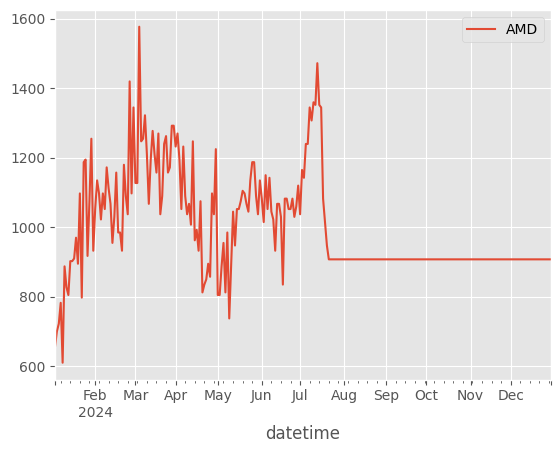

In [28]:
evb_backtest.portfolio._equity.plot(y = 'AMD')

In [20]:
evb_backtest.portfolio.plot_portfolio()

In [21]:
evb_backtest.portfolio.aggregate()

Start                                                    2024-01-03 00:00:00
End                                                      2024-12-31 00:00:00
Duration                                                   363 days 00:00:00
Exposure Time [%]                                                      100.0
Equity Final [$]                                                    60726.43
Equity Peak [$]                                                  72524.58335
Return [%]                                                        206.120978
Buy & Hold Return [%]                                               53.33729
CAGR [%]                                                           208.01381
Volatility Ann. [%]                                                57.038772
Sharpe Ratio                                                        2.257034
Sortino Ratio                                                       3.440639
Skew                                                                0.517778

In [22]:

pd.set_option('display.max_rows', 10000)
evb_backtest.portfolio.get_all_positions()

long                short  \
datetime   symbol                                            
2024-01-03 BA        [BA20240920C260]     [BA20240920C265]   
           AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
2024-01-04 BA        [BA20240920C260]     [BA20240920C265]   
           AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
2024-01-05 BA        [BA20240920C260]     [BA20240920C265]   
           AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
2024-01-08 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
2024-01-09 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
2024-01-10 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
2024-01-11 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
2024-01-12 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
2024-01-15 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
2024-01-16 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
2024-01-17 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-01-18 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-01-19 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-01-22 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-01-23 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-01-24 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-01-25 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-01-26 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-01-29 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-01-30 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-01-31 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-02-01 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-02-02 AMD      [AMD20240920C140]    [AMD20240920C145]   
           COST    [COST20240920C695]   [COST20240920C700]   
           NVDA    [NVDA20241220C930]   [NVDA20241220C950]   
2024-02-05 AMD      [AMD20240920C140]    [AMD20240920C145]   
   

In [23]:


""""
Why do these two return weird stuff after run?
    current_weighted_holdings
    current_positions

I can't reconcile the cost with the data (NVM, haha)

"""
# evb_backtest.portfolio.all_positions

'"\nWhy do these two return weird stuff after run?\n    current_weighted_holdings\n    current_positions\n\nI can\'t reconcile the cost with the data (NVM, haha)\n\n'

In [24]:
order_cache['2024-01-03']

{'BA': {'result': 'SUCCESSFUL',
  'data': {'long': ['BA20240920C260'],
   'short': ['BA20240920C265'],
   'trade_id': '&L:BA20240920C260&S:BA20240920C265',
   'close': 1.549999999999999}},
 'AMD': {'result': 'SUCCESSFUL',
  'data': {'long': ['AMD20240920C140'],
   'short': ['AMD20240920C145'],
   'trade_id': '&L:AMD20240920C140&S:AMD20240920C145',
   'close': 3.299999999999997}},
 'COST': {'result': 'SUCCESSFUL',
  'data': {'long': ['COST20240920C695'],
   'short': ['COST20240920C700'],
   'trade_id': '&L:COST20240920C695&S:COST20240920C700',
   'close': 4.899999999999977}},
 'NFLX': {'result': 'MAX_PRICE_TOO_LOW', 'data': None}}

## Extend for  get_port_stats
- Buy & Hold
- Dates
- Trades
- _strategy in Aggregate
- The function

In [25]:
evb_backtest.trades.to_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/output/profitable_trades_options_{key}.csv')

AttributeError: 'OptionSignalBacktest' object has no attribute 'trades'